# 02936 Bayesian Data Analysis
## Extending Bepipred epitope prediction model
#### by Jakob Nissen (s170001) and Dennis Pohl (s190347)
## Introduction
In this project, we're exploring Bayesian extensions of an existing deep learning model, Bepipred, which predicts a property of proteins. Understanding this necessitates a brief introduction to the structure of proteins as well as the function of Bepipred, which we will cover in the next chapters.

This project was done in loose collaboration with Birkir Reynisson (BR) and Martil Closter Jespersen (MCJ). We decided early in the project to split into two groups because smaller ground allow each group member to contribute more meaningfully. The data, the original Bepipred model and a description of the scientific problem was provided by MCJ. Early in the project, we held meetings with BR & MCJ to get an idea about possible approaches to the project. Other than sharing the data, the Bepipred model and the initial meetings, the two groups have worked completely independently.

### Proteins and amino acids
Most biochemical reactions in the body are catalyzed by proteins. Proteins also serve as building blocks of tissues such as hair, nails, skin and muscle. For this reason, almost all molecular biological object of study involves interaction of proteins.

Proteins are synthesized in the body as a linear polymer of a kind of small polar molecule called amino acids. In natural proteins, 20 different amino acids are used. Hence, the chemical structure of a protein can conveniently be perfectly represented as a linear string of letters from a 20-character alphabet, by convention "ACDEFGHIKLMNPQRSTVWY". The linear chain of amino acids is also known as the primary protein structure.

Hydrogen bonds in the polypeptide backbone of the amino acid string can introduce secondary structures. The most common secondary structures are $\alpha$-helices, $\beta$-sheets and loops. In brief, $\alpha$-helices are helical coils whereas $\beta$-sheets are formed by (multiple) polypeptide-chains which lie next to each other bound by hydrogen bonds. Loops are loose flexible turns formed by 2-16 amino acid residues and are of particular interest in this project, as they often contain and expose the epitope to the protein surface.

During and immediately after synthesis, this chain of amino acid begins to electrostatically interact with itself and the surrounding water and ions. These forces fold the chain into a well-defined three-dimensional structure that is critical for the function of the protein. Although this process is deterministic for a given amino acid sequence, and relies on nothing other than the physiochemical properties of the protein chain, predicting the folding of an amino acid chain is one of the most fundamental unsolved problems in science.

#### Antibodies and epitopes
Antibodies are a group of proteins that can specifically recognize and bind to different classes of antigens through epitope regions. Antigens are foreign proteins, polysaccharides or other molecules, often found on bacterial or viral surface structures that can enter our body and induce an immune response. Generally, the human body is capable of detecting antigens through B cells carrying antibodies on their surface which will recognize epitope regions (which are usually 5-8 amino acids in length) on the surface of the antigen. Epitopes can fold into many complex three-dimensional conformations, thereby impairing the efficiency of an antibody to recognize and bind to the antigen. However, if an antibody was able to bind to an epitope it will render the antigen harmless by e.g. blocking its surface, thereby preventing interactions with the antigen's target receptor.

### Bepipred
Bepipred is a computational tool developed by Martin Closter Jespersen (MCJ) to predict which amino acids of a protein constitute epitopes, taking only the amino acid sequence as input. The input is thus a string of length N of the 20-letter amino acid alphabet. The output is a vector of length N of the prediction score in \[0, 1), where 0 indicates low probability of the corresponding amino acid being an epitope.

Bepipred is a convolutional neural network, that predicts the score of each amino acid based on a sliding window of size 9, i.e. the data of the central amino acid for which the score is predicted, as well as the 4 flanking amino acids on each side. Each sliding window leads to a prediction independent of the other sliding windows in the protein. Bepipred uses the features `rsa`, `seq`, `q3` and `disorder` (described in the dataset section).

### Dataset
Our dataset is a JSON file containing 190 proteins. The dataset have been curated such that no protein share a close evolutionary relationship with any other from the dataset, nor with any protein that Bepipred has been trained on.

A total of 16 features per protein in the dataset is avaiable. We will focus on the attributes that are potentially relevant here:

__epitope__:
A vector of 1 where the amino acid is an epitope and 0 where it is not. These are the true labels.

__preds__:
A vector of floats \[0, 1) with the output of Bepipred

__disorder__:
A vector of floats \[0, 1) with the a score signifying the predicted freedom of movement of the given amino acid, where 0 indicates the amino acid is locked into place and 1 indicating the amino acid can move as freely as possible.

__q3__:
A string of characters from the alphabet "CHE", signifying the predicted local "secondary" structure classified in either coil (C), helix (H) or sheet (E).

__q3_prob__:
A vector of vectors, where each inner vector has three elements represents the probability of the local structure being coil, helix or sheet, respectively.

__rsa__:
The predicted relative exposed surface area of the amino acid. This is constrained in [0, 1], where 0 signifies an amino acid completely buried on the inside of the protein, and 1 signifying the amino acid free-floating in the solution.

__seq__:
A string of chracters from the alphabet "ACDEFGHIKLMNPQRSTVWXY" representing the amino acid sequence of the protein, as well as X for unknown amino acid.

### Objectives of this project
Proteins are large biomolecules consisting of long chains of amino acid residues which usually fold into highly complex 3-dimensional structures. Proteins perform many critical functions in our human body but its function highly depends on its tertiary structure. Predicting epitope regions of a protein remains a difficult task as the folding of a protein is highly complex. In this project we worked with the output produced by Bepipred, and focused in particular on the prediction of epitopes in proteins.

The aim of this project is to enhance Bepipred's epitope prediction using Bayesian statistics. We started out with simple Bayesian models and implemented more sophisticated (multiparameter) models, by e.g. taking into consideration protein lengths or amino acid frequency. Each Bayesian model is cross-validated by computing Pareto smoothed importance sampling leave-one-out, or short PSIS-LOO. Finally we determine and propose the best performing model.

#### Set the path to the data and import packages

In [16]:
# dir
PSIS_DIRECTORY = '../../assignments'
DATA_PATH = '../../bepipred3.json'

# packages
import sys
sys.path.append(PSIS_DIRECTORY)
import json
import numpy as np
import pystan
import matplotlib.pyplot as plt
import scipy
from math import log
from collections import Counter
from scipy.special import logit, expit
#from psis import psisloo
import psis
import plot_tools
import arviz as az # For visualization and loo
az.style.use('seaborn-darkgrid')

# load data
with open(DATA_PATH) as file:
    data = json.load(file)

#### Data preparation

Inspection of the data reveals that one protein contains one amino acid labeled 'X' (any amino acid). Since the sliding windows are predicted independently, we have decided to remove this amino acid instead of discarding the protein.

In [17]:
# Check that all data has the same amino acids, predictions and labels
for protein in data:
    assert len(protein['epitope']) == len(protein['preds']) == len(protein['seq'])

# Remove 'X' from all proteins they are present in
for protein in data:
    if 'X' in protein['seq']:
        x_positions = [i for i,n in enumerate(protein['seq']) if n == 'X']
        for k, v in protein.items():
            if not hasattr(v, "__len__") or len(v) != len(protein['seq']):
                continue
            newdata = [x for i,x in enumerate(v) if i not in x_positions]
            if isinstance(v, str):
                newdata = ''.join(newdata)
            protein[k] = newdata

### Data exploration

To get a first impression of our data, we look at the length of the proteins. The mean protein length is about 255 amino acids, indicated below by the black dotted line.

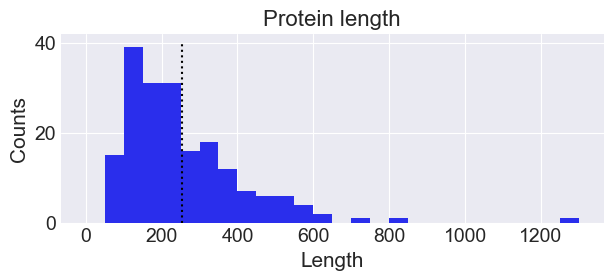

In [44]:
plt.figure(figsize=(7, 2.5))
plt.hist([len(protein['seq']) for protein in data], bins=np.linspace(0, 1300, 27))
plt.vlines(np.mean([len(protein['seq']) for protein in data]), 0, 40, linestyles='dotted')
plt.title("Protein length")
plt.xlabel("Length")
plt.ylabel("Counts")
plt.show()

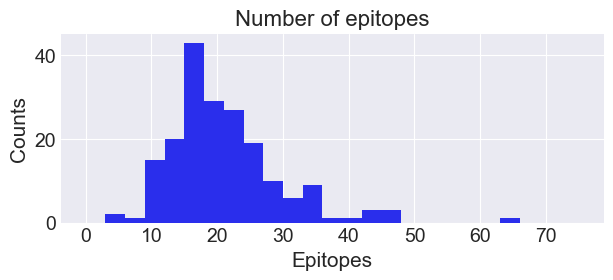

In [45]:
plt.figure(figsize=(7, 2.5))
plt.hist([sum(protein['epitope']) for protein in data], bins=np.linspace(0, 75, 26))
plt.title("Number of epitopes")
plt.xlabel("Epitopes")
plt.ylabel("Counts")
plt.show()

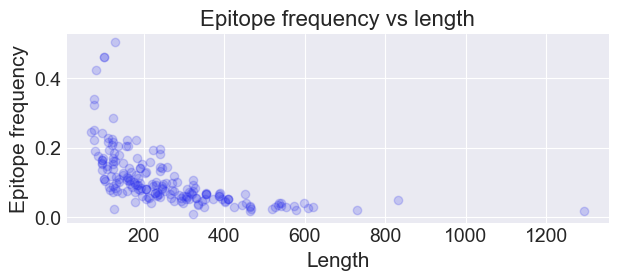

In [49]:
plt.figure(figsize=(7, 2.5))
plt.plot([len(i['epitope']) for i in data], [sum(i['epitope'])/len(i['epitope']) for i in data], 'o', alpha = 0.2)
plt.title("Epitope frequency vs length")
plt.xlabel("Length")
plt.ylabel("Epitope frequency")
plt.show()

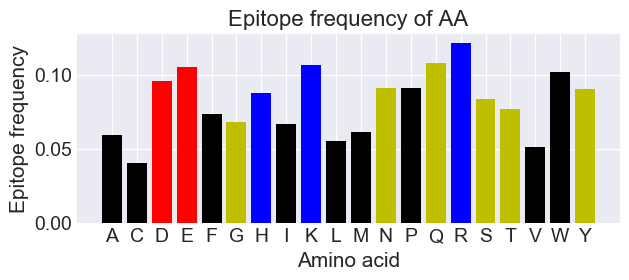

In [50]:
counts = Counter()
epitopes = Counter()
for protein in data:
    for aa, isepitope in zip(protein['seq'], protein['epitope']):
        counts[aa] += 1
        if isepitope:
            epitopes[aa] += 1
freq = {aa: epitopes[aa]/counts[aa] for aa in counts if aa != 'X'}

# plot
plt.figure(figsize=(7, 2.5))
ind = {aa:i for i, aa in enumerate(sorted(freq))}
aasets = [('GSTYNQ', 'y'),
         ('ACFILMVWP', 'k'),
         ('DE', 'r'),
         ('RHK', 'b')]
for aaset, color in aasets:
    for aa in aaset:
        plt.bar(ind[aa], freq[aa], color=color)
plt.xticks(range(len(freq)), sorted(freq))
plt.title("Epitope frequency of AA")
plt.xlabel("Amino acid")
plt.ylabel("Epitope frequency")
plt.show()

### <span style="color:red">Can't find the ASA of epitopes box plot and ROC curves + Enrichment</span>

#### Functions for further analysis

In [5]:
# Effective number of parameters
def p_eff(lppd_loo_cv, log_like):
    """
    lppd_loo_cv: float
    log_like: (n x m) log-likelihood of m data points, given n posterior samples.
    """
    lppd = np.sum(np.log(np.mean(np.exp(log_like), axis=0)))
    return lppd - lppd_loo_cv

## Analysis

#### Null model

For a baseline, we simply predict a constant probability of each amino acid being an epitope. Hopefully, all models should perform better than this.

$epitopes \sim uniform(\alpha)$

In [59]:
# PSIS-LOO code + plot for this model

# Add in features
n_aa = sum(len(protein['seq']) for protein in data)

aa_set = set()
for protein in data:
    aa_set.update(set(protein['seq']))
aa_index = {aa:i+1 for i,aa in enumerate(aa_set)} # Stan is 1-indexed

epitopes = np.empty(n_aa, dtype=np.int32)
scores = np.empty(n_aa, dtype=np.float32)
aa = np.empty(n_aa, dtype=np.int32)
inv_score_sum = np.empty(n_aa, dtype=np.float32)
inv_length = np.empty(n_aa, dtype=np.float32)

i = 0
for protein in data:
    length = len(protein['seq'])
    sum_scores = sum(protein['preds'])
    
    epitopes[i:i+length] = protein['epitope']
    scores[i:i+length] = protein['preds']
    aa[i:i+length] = [aa_index[i] for i in protein['seq']]
    inv_score_sum[i:i+length] = 1/sum_scores
    inv_length[i:i+length] = 1/length
    
    i += length
    
standata = {'n_aa': n_aa,
            'n_classes': len(aa_index),
            'epitopes': epitopes,
            'scores': scores,
            'aa': aa,
            'inv_score_sum': inv_score_sum,
            'inv_length': inv_length}

n_epitopes = sum(standata['epitopes'])
logps = np.array([log(1 - n_epitopes / standata['n_aa']), log(n_epitopes / standata['n_aa'])])
model_null_loglik = logps[standata['epitopes']].sum()
print("PSIS-LOO: {:.2f}".format(model_null_loglik))

PSIS-LOO: -13544.84


#### Model 0: Bepipred model

As the purpose of our project is to enhance Bepipred's prediction, the second baseline to establish is a model which simply interpretates Bepipreds output scores as probabilities. Building a model to beat the performance of this baseline is the true goal of the project.

$epitopes \sim uniform(predictions)$

In [63]:
model_0_loglik = np.empty((1, len(standata['scores'])), dtype=np.float32)
mask = standata['epitopes'] == 1
model_0_loglik[0, mask] = np.log(standata['scores'][mask])
model_0_loglik[0, ~mask] = np.log(1 - standata['scores'][~mask])

# No sampling, so we use the loglikelihood
print("PSIS-LOO: {:.2f}".format(model_0_loglik.sum()))

PSIS-LOO: -12883.65


#### Model 1: Logistic model

Bepipred is a deep neural network, and is therefore fitted to minimize some loss function which is not necessarily related to the log likelihood. The next step towards a probabilistic model is a simple logistic regression that uses only Bepipreds output to calculate a probability of an amino acid being an epitope.

$epitopes \sim BernoulliLogit(\alpha + \beta \times predictions)$

Our implemented Stan model looks like the following:

In [ ]:
# %load "models/pooled.stan"
data {
    int<lower=0> n_aa;
    int<lower=0,upper=1> epitopes[n_aa]; // binarize to 0 or 1
    vector[n_aa] scores; // output of bepipred
}
parameters {
    real alpha;
    real beta;
}
model {
    epitopes ~ bernoulli_logit(alpha + beta * scores);
}

In [64]:
# open model
with open('models/pooled.stan') as f:
    model_1_code = f.read()

model_1 = pystan.StanModel(model_code=model_1_code, model_name='Model_1')
fit_model_1 = model_1.sampling(data=standata)
print(fit_model_1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL Model_1_16473ccc58d6ccdd3f35e7f8c8a0e157 NOW.
/Users/dpohl/anaconda3/envs/PyStan/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/zq/wfnwl84j08q68c6t__f3vs200000gn/T/tmpgplnaqm4/stanfit4Model_1_16473ccc58d6ccdd3f35e7f8c8a0e157_714376441792739923.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Inference for Stan model: Model_1_16473ccc58d6ccdd3f35e7f8c8a0e157.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha  -3.58  1.5e-3   0.04  -3.66   -3.6  -3.58  -3.55  -3.49    815    1.0
beta   12.62    0.01   0.38  11.88  12.36  12.61  12.88  13.37    774    1.0
lp__  -1.3e4    0.03   0.97 -1.3e4 -1.3e4 -1.3e4 -1.3e4 -1.3e4   1112    1.0

Samples were drawn using NUTS at Wed May 15 16:27:41 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [68]:
extract_1 = fit_model_1.extract()
# Calculate PSIS LOO
n_obs = len(extract_1['alpha'])
model_1_loglik = np.empty((n_obs, standata['n_aa']), dtype=np.float32)
mask = standata['epitopes'] == 1
for i in range(n_obs):
    alpha = extract_1['alpha'][i]
    beta = extract_1['beta'][i]
    ps = expit(alpha + beta * standata['scores'])
    ps[~mask] = 1-ps[~mask]
    model_1_loglik[i] = np.log(ps)
model_1_loo, model_1_loos, model_1_ks = psis.psisloo(model_1_loglik)
print("PSIS-LOO: {:.2f}".format(model_1_loo))

PSIS-LOO: -12992.09


In [ ]:
# Posterior sampling plot

In [ ]:
# PSIS-LOO code + plot for this model

According to the PSIS-LOO value, this model performed worse than the Bepipred model (model 0). It might suggest that logistic models are not suitable for this problem.

#### Model 2: Separate model

The separate model does not include any pooling and will generate an estimate for each amino acid. This model will treat the amino acids independently from each other, means each amino acid estimate is unbiased and only based on its own <span style="color:red">(prediction score)</span>. This model has two parameters ($\alpha$ and $\beta$) for each amino acid estimate.

$epitopes \sim expit(\alpha_{aa} + \beta_{aa} \times pred)$

In [6]:
# load model
with open('models/separate.stan') as f:
    model_3_code = f.read()        

# prepare data
total_aminoacids = 0
for i, protein in enumerate(data):
    if not len(protein['epitope']) == len(protein['preds']):
        continue
    total_aminoacids += len(protein['epitope'])
    
epitopes = np.empty(total_aminoacids, dtype=np.int)
scores = np.empty(total_aminoacids, dtype=np.float)
aas = np.empty(total_aminoacids, dtype=np.int)

var_set = set()
for i in data:
    var_set = var_set.union(i["seq"])
mydict = {j:i+1 for i,j in enumerate(var_set)}

index = 0
for protein in data:
    if not len(protein['epitope']) == len(protein['preds']):
        continue
    length = len(protein['epitope'])
    epitopes[index:index+length] = protein['epitope']
    scores[index:index+length] = protein['preds']
    aas[index:index+length] = [mydict[i] for i in protein["seq"]]
    index += length
    
# run stan model
standata_3 = {
    'classes': len(mydict),
    'total_aa': total_aminoacids,
    'aa': aas,
    'epitopes': epitopes,
    'scores': scores
}
model_3 = pystan.StanModel(model_code=model_3_code, model_name='Model_3')
fit_3 = model_3.sampling(data=standata_3)
print(fit_3)

Inference for Stan model: Model_3_b58402f9a50f0679580b6a2d448ce996.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]   -3.85  2.2e-3   0.17   -4.2  -3.97  -3.85  -3.74  -3.52   6218    1.0
alpha[2]   -3.67  2.4e-3   0.19  -4.04   -3.8  -3.67  -3.54   -3.3   5929    1.0
alpha[3]   -3.28  1.9e-3   0.15  -3.59  -3.38  -3.28  -3.18  -2.98   6654    1.0
alpha[4]   -3.41  2.9e-3   0.21  -3.84  -3.56  -3.41  -3.26  -3.01   5443    1.0
alpha[5]   -3.95  2.1e-3   0.17  -4.29  -4.06  -3.94  -3.83  -3.62   6578    1.0
alpha[6]   -3.52  3.2e-3   0.24  -4.01  -3.68  -3.51  -3.35  -3.08   5758    1.0
alpha[7]   -3.41  2.9e-3   0.22  -3.84  -3.56  -3.41  -3.27   -3.0   5526    1.0
alpha[8]   -3.76  2.4e-3    0.2  -4.17   -3.9  -3.76  -3.63  -3.39   7022    1.0
alpha[9]   -4.16  1.9e-3   0.16  -4.47  -4.27  -4.16  -4.05  -3.86   7033    1.0
alph

All $\hat{R}$ values equal 1.0 means chains have converged. Effective sample size ($N_{eff}$) is also relatively high, which is a measure of autocorrelation within the chains and can increase the uncertainty in estimates.

Text(0.5, 1.0, 'k-values')

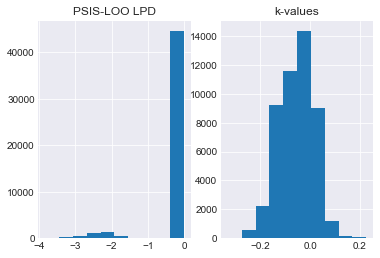

In [18]:
# PSIS diagnostic plot: Pareto k-values
plt.subplot(122)
plt.hist(model_3_ks) # or plt.plot
plt.title('k-values')

Some thoughts + from documentation
- Reliability and approximate convergence can be assessed using the estimates for the shape parameter *k* of the generalized Pareto distribution:
- However, the PSIS effective sample size estimate will be over-optimistic when the estimate of 𝑘 is greater than 0.7.
- If *k*>0.7 we observe impractical convergence rates and unreliable Monte Carlo error estimates.
- (All Pareto k-values are <0.7)

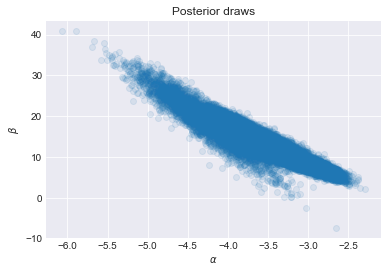

In [15]:
# Posterior sampling
plt.scatter(extract_3['alpha'], extract_3['beta'], alpha = 0.1)
plt.title('Posterior draws')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.show()

In [9]:
# Calculate PSIS-LOO
extract_3 = fit_3.extract()
n_obs = len(extract_3['alpha'])
model_3_loglik = np.empty((n_obs, standata_3['total_aa']), dtype=np.float32)
mask = standata_3['epitopes'] == 1
for i in range(4000):
    a = extract_3['alpha'][i][aas-1]
    b = extract_3['beta'][i][aas-1]
    ps = expit(a + b*standata_3['scores'])
    ps[~mask] = 1-ps[~mask]
    model_3_loglik[i] = np.log(ps)
    
model_3_loo, model_3_loos, model_3_ks = psis.psisloo(model_3_loglik)

print("PSIS-LOO: {:.2f}".format(model_3_loo))
print("Number of effective parameters (p-eff): {:.2f}".format(p_eff(model_3_loo, model_3_loglik)))

PSIS-LOO: -12977.29
Number of effective parameters (p-eff): 36.42


In [ ]:
# PSIS-LOO plot for this model

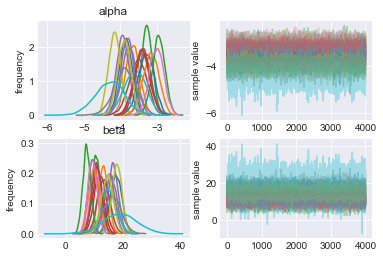

In [23]:
fit_3.plot()
plt.show()

In [34]:
import stan_utility
stan_utility.check_treedepth(fit_3)

0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)


In [35]:
stan_utility.check_energy(fit_3)

In [36]:
stan_utility.check_div(fit_3)

0.0 of 4000 iterations ended with a divergence (0.0%)


In [39]:
light="#DCBCBC"
light_highlight="#C79999"
mid="#B97C7C"
mid_highlight="#A25050"
dark="#8F2727"
dark_highlight="#7C0000"
green="#00FF00"

nondiv_params, div_params = stan_utility.partition_div(fit_3)

plt.scatter([x[0] for x in nondiv_params['alpha']], nondiv_params['beta'], \
             color = mid_highlight, alpha=0.05)
plt.scatter([x[0] for x in div_params['alpha']], div_params['beta'], \
             color = green, alpha=0.5)

plt.gca().set_xlabel("alpha")
plt.gca().set_ylabel("beta")

plt.show()

In [46]:
nondiv_params

{'alpha': array([[-3.799463  , -3.52174993, -3.27294032, ..., -3.96903796,
         -3.74604236, -4.22413223],
        [-3.82265735, -3.71474588, -3.1676822 , ..., -3.84967575,
         -3.78918935, -4.16186232],
        [-3.94534061, -3.44305224, -3.38393439, ..., -3.9465641 ,
         -4.02812586, -4.1492643 ],
        ...,
        [-3.68689764, -3.53287366, -3.11319563, ..., -3.49640033,
         -3.87425445, -3.80037028],
        [-4.03251299, -3.766632  , -3.23639238, ..., -3.98352919,
         -3.92433961, -4.81711391],
        [-3.85017523, -3.60696873, -3.47492942, ..., -3.37796534,
         -3.86368455, -3.84210142]]),
 'beta': array([[19.23904618, 11.87090398, 10.37013683, ..., 14.87369239,
         12.59536381, 19.2991686 ],
        [16.4065231 , 14.18238344,  9.56121595, ..., 15.92138349,
         12.62441014, 18.91297753],
        [18.0782318 , 10.83047254, 12.2002109 , ..., 16.9666353 ,
         15.76198211, 18.85210571],
        ...,
        [17.43981571, 11.28543715,  9

In [47]:
div_params

{'alpha': array([], shape=(0, 20), dtype=float64),
 'beta': array([], shape=(0, 20), dtype=float64)}

#### Model 3: Hierarchical model

This model is an extension of the previous, where we assume the different $\alpha$ values are not truly independent, but in fact related by being from the same distribtuion, and thus can inform each other.

$\alpha \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha})$

$epitopes \sim expit(\alpha_{aa} + \beta \times pred)$

#### Model 4: Hierarchical model + length

This model is identical to the previous model, except that a term is added to the logistic regression which takes the length of the protein into account.

Studying the data, we can see that the long proteins have fewer epitopes per amino acid than short ones do (see figure below). The signal is remarkable, and because Bepipred predicts on only a small window of amino acids, we believe it is not able to take this into account.

$\alpha \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha})$

$epitopes \sim expit(\alpha_{aa} + \beta \times pred + \gamma \times \frac{1}{length})$

In [21]:
def setplot(title, xlabel, ylabel):
    plt.title(title, fontsize=20)
    plt.tick_params(labelsize=12)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

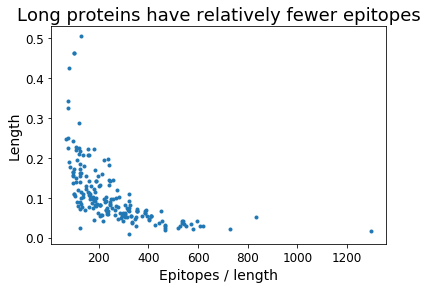

In [34]:
xs = [len(protein['seq']) for protein in data]
ys = [sum(protein['epitope'])/i for protein, i in zip(data, xs)]
plt.plot(xs, ys, '.')
setplot('Long proteins have relatively fewer epitopes', 'Epitopes / length', 'Length')

#### Model 5: Hierarchical model + sum of scores

$\alpha \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha})$

$epitopes \sim expit(\alpha_{aa} + \beta \times pred + \gamma \times \frac{1}{\sum{pred}})$

#### Model 6: Separate model + sum of scores

$epitopes \sim expit(\alpha_{aa} + \beta_{aa} \times pred + \gamma \times \frac{1}{\sum{pred}})$

#### Model 7: Model 6 w/o Bepipred

$epitopes \sim expit(\alpha_{aa} + \gamma \times \frac{1}{\sum{length}})$

## Overview of results
blabla

<span style="color:red">The following: Arbitrary PSIS-LOO values. Need to replace them</span>

Pareto smoothed importance sampling leave-one-out (PSIS-LOO) cross-validation was used to estimate the predictive performance of each model. The following is a summary of the PSIS-LOO values obtained for each respective model:

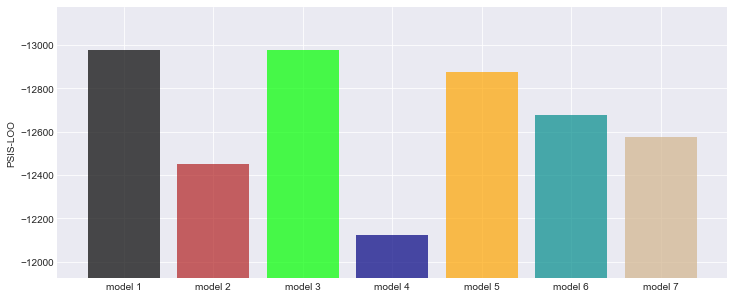

In [13]:
PSIS_LOO_comp = {}
PSIS_LOO_comp["model 1"] = -12977.486
PSIS_LOO_comp["model 2"] = -12450.450
PSIS_LOO_comp["model 3"] = model_3_loo
PSIS_LOO_comp["model 4"] = -12123.123
PSIS_LOO_comp["model 5"] = -12874.673
PSIS_LOO_comp["model 6"] = -12674.673
PSIS_LOO_comp["model 7"] = -12574.673

f = plt.figure(figsize = (12, 5))
x = PSIS_LOO_comp.keys()
y = PSIS_LOO_comp.values()
maximum = max(PSIS_LOO_comp.values()) + 200
minimum = min(PSIS_LOO_comp.values()) - 200

plt.bar(x, y, alpha=0.7, color=['black', 'firebrick', 'lime', 'navy', 'orange', 'darkcyan', 'tan'])
plt.ylim(maximum, minimum)
plt.ylabel("PSIS-LOO")
plt.show()

## Conclusion
blabla

In [37]:
1/200

0.005